In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

In [2]:
df = pd.read_csv("marketing_data.csv")

In [8]:
# Section 1: Exploratory Data Assessment


def exploratory_data_assessment(df):
    print(" Exploratory Data Assessment ")
    display = None
    # Basic shape and types
    print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}\n")
    print("Column dtypes:")
    print(df.dtypes)
    print("\nMissing values per column:")
    print(df.isnull().sum())
    

    # Datetime conversion
    if 'Dt_Customer' in df.columns:
        df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], errors='coerce')
        print('\nConverted Dt_Customer to datetime (errors->NaT)')
    
    
    # Outlier detection using IQR for numeric columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    print('\nNumeric columns detected:', numeric_cols)
    outlier_summary = {}
    for col in numeric_cols:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        outlier_count = ((df[col] < lower) | (df[col] > upper)).sum()
        outlier_summary[col] = int(outlier_count)
    print('\nOutlier counts (IQR method):')
    print(outlier_summary)
    
    
    # Suggested handling notes
    print('\nSuggested handling for missing values and outliers:')
    print('- For missing demographic fields (Education, Income): consider imputing with group medians or a separate category "Unknown"')
    print('- For income extreme outliers: cap at 99th percentile or log-transform if modeling')
    print('- For transaction amounts: consider log(1+x) transform to reduce skew')
    
    
    # Feature engineering ideas
    print('\nDerived columns suggested:')
    print("- Age = current_year - Year_Birth")
    print("- Total_Spent = sum of Mnt* columns")
    print("- Tenure_months = months since Dt_Customer")
    print("- Avg_purchase_value = Total_Spent / (NumStorePurchases + NumWebPurchases + NumCatalogPurchases) (guard divide-by-zero)")


    return df


In [10]:
# run EDA if data present
if not df.empty:
    df = exploratory_data_assessment(df)

 Exploratory Data Assessment 
Rows: 2240, Columns: 28

Column dtypes:
ID                      int64
Year_Birth              int64
Education              object
Marital_Status         object
 Income                object
Kidhome                 int64
Teenhome                int64
Dt_Customer            object
Recency                 int64
MntWines                int64
MntFruits               int64
MntMeatProducts         int64
MntFishProducts         int64
MntSweetProducts        int64
MntGoldProds            int64
NumDealsPurchases       int64
NumWebPurchases         int64
NumCatalogPurchases     int64
NumStorePurchases       int64
NumWebVisitsMonth       int64
AcceptedCmp3            int64
AcceptedCmp4            int64
AcceptedCmp5            int64
AcceptedCmp1            int64
AcceptedCmp2            int64
Response                int64
Complain                int64
Country                object
dtype: object

Missing values per column:
ID                      0
Year_Birth            

C:\Users\prati\AppData\Local\Temp\ipykernel_29560\1618237075.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], errors='coerce')



Converted Dt_Customer to datetime (errors->NaT)

Numeric columns detected: ['ID', 'Year_Birth', 'Kidhome', 'Teenhome', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Response', 'Complain']

Outlier counts (IQR method):
{'ID': 0, 'Year_Birth': 3, 'Kidhome': 0, 'Teenhome': 0, 'Recency': 0, 'MntWines': 35, 'MntFruits': 227, 'MntMeatProducts': 175, 'MntFishProducts': 223, 'MntSweetProducts': 248, 'MntGoldProds': 207, 'NumDealsPurchases': 86, 'NumWebPurchases': 4, 'NumCatalogPurchases': 23, 'NumStorePurchases': 0, 'NumWebVisitsMonth': 8, 'AcceptedCmp3': 163, 'AcceptedCmp4': 167, 'AcceptedCmp5': 163, 'AcceptedCmp1': 144, 'AcceptedCmp2': 30, 'Response': 334, 'Complain': 21}

Suggested handling for missing values and outliers:
- For missing demogra

In [11]:
# Section 2: Behavioral & Statistical Insights

# Preprocessing helpers

def preprocess_for_behavioral(df):
    df = df.copy()
    # Age
    current_year = pd.Timestamp.now().year
    if 'Year_Birth' in df.columns:
        df['Age'] = current_year - df['Year_Birth']
    # Total spent
    amt_cols = [c for c in df.columns if c.startswith('Mnt')]
    df['Total_Spent'] = df[amt_cols].sum(axis=1)
    # Tenure
    if 'Dt_Customer' in df.columns:
        df['Tenure_Days'] = (pd.Timestamp.now() - df['Dt_Customer']).dt.days
        df['Tenure_Months'] = (df['Tenure_Days'] / 30.44).round(1)
    # Purchase channels total
    df['Total_Purchases'] = df[['NumDealsPurchases','NumWebPurchases','NumCatalogPurchases','NumStorePurchases']].sum(axis=1)
    # Average purchase value
    df['Avg_Purchase_Value'] = df['Total_Spent'] / df['Total_Purchases'].replace({0: np.nan})
    # Binary flag for high gold spenders
    if 'MntGoldProds' in df.columns:
        threshold = df['MntGoldProds'].quantile(0.75)
        df['High_Gold_Spender'] = (df['MntGoldProds'] >= threshold).astype(int)
    # Binning income
    if 'Income' in df.columns:
        df['Income_log'] = np.log1p(df['Income'].fillna(0))
        est = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='quantile')
        try:
            df['Income_Bin'] = est.fit_transform(df[['Income']].fillna(df['Income'].median())).astype(int).ravel()
        except Exception:
            df['Income_Bin'] = pd.qcut(df['Income'].fillna(df['Income'].median()), q=4, labels=False, duplicates='drop').astype(float)
    return df


if not df.empty:
    df = preprocess_for_behavioral(df)

In [12]:
# Analysis 1: Key drivers behind in-store purchase frequency


def analyze_instore_drivers(df):
    print('\n--- Drivers of NumStorePurchases ---')
    # Simple correlations with NumStorePurchases
    target = 'NumStorePurchases'
    numeric = df.select_dtypes(include=[np.number]).columns.tolist()
    corr = df[numeric].corr()[target].sort_values(ascending=False)
    print('\nTop correlations with NumStorePurchases:')
    print(corr.head(10))

    
    # Build a simple regression model to explain NumStorePurchases
    features = ['Age','Income','Tenure_Months','NumWebVisitsMonth','Total_Spent','NumDealsPurchases','NumWebPurchases']
    features = [f for f in features if f in df.columns]
    df_model = df.dropna(subset=features+[target])
    if len(df_model) < 50:
        print('Not enough complete rows for regression. Need >=50 rows.')
        return
    X = df_model[features].values
    y = df_model[target].values
    lr = LinearRegression()
    lr.fit(X,y)
    y_pred = lr.predict(X)
    print('\nRegression R^2:', r2_score(y,y_pred))
    coefs = pd.Series(lr.coef_, index=features).sort_values(key=abs, ascending=False)
    print('\nRegression coefficients (magnitude sorted):')
    print(coefs)
    print('\nInterpretation: positive coefficient means the feature associates with more store purchases (holding others constant).')
    

if not df.empty:
    analyze_instore_drivers(df)


--- Drivers of NumStorePurchases ---

Top correlations with NumStorePurchases:
NumStorePurchases      1.000000
Total_Purchases        0.820259
Total_Spent            0.674669
MntWines               0.642100
NumCatalogPurchases    0.518738
NumWebPurchases        0.502713
MntMeatProducts        0.479659
MntFruits              0.461758
MntFishProducts        0.459855
MntSweetProducts       0.448756
Name: NumStorePurchases, dtype: float64

Regression R^2: 0.5271100985455631

Regression coefficients (magnitude sorted):
NumWebVisitsMonth   -0.338667
NumWebPurchases      0.265317
NumDealsPurchases    0.205406
Tenure_Months        0.020110
Age                  0.002800
Total_Spent          0.002324
dtype: float64

Interpretation: positive coefficient means the feature associates with more store purchases (holding others constant).


In [13]:
# Analysis 2: US vs Others


def compare_us_vs_others(df):
    print('\n--- US vs Others: purchasing behavior ---')
    if 'Country' not in df.columns:
        print('Country column missing')
        return
    df['Is_US'] = (df['Country'] == 'US')
    cols_to_compare = ['Total_Spent','NumStorePurchases','NumWebPurchases','NumWebVisitsMonth']
    for col in cols_to_compare:
        if col in df.columns:
            us = df[df['Is_US']][col].dropna()
            other = df[~df['Is_US']][col].dropna()
            if len(us) < 10 or len(other) < 10:
                print(f'Not enough data to compare for {col}')
                continue
            tstat, pval = stats.ttest_ind(us, other, equal_var=False)
            print(f"{col}: US mean={us.mean():.2f}, Others mean={other.mean():.2f}, t-stat={tstat:.3f}, p={pval:.3f}")


if not df.empty:
    compare_us_vs_others(df)


--- US vs Others: purchasing behavior ---
Total_Spent: US mean=622.77, Others mean=604.93, t-stat=0.324, p=0.746
NumStorePurchases: US mean=6.04, Others mean=5.78, t-stat=0.786, p=0.433
NumWebPurchases: US mean=4.44, Others mean=4.07, t-stat=1.404, p=0.163
NumWebVisitsMonth: US mean=5.60, Others mean=5.30, t-stat=1.151, p=0.252


In [15]:
# Analysis 3: Gold spending vs in-store purchases


def gold_vs_store(df):
    print('\n--- High gold spenders vs store purchases ---')
    if 'High_Gold_Spender' not in df.columns:
        print('No gold spender flag')
        return
    g0 = df[df['High_Gold_Spender'] == 0]['NumStorePurchases'].dropna()
    g1 = df[df['High_Gold_Spender'] == 1]['NumStorePurchases'].dropna()
    if len(g0) < 10 or len(g1) < 10:
        print('Not enough samples for statistical test')
        return
    tstat, pval = stats.ttest_ind(g1, g0, equal_var=False)
    print(f"High gold mean store purchases={g1.mean():.2f}, Others={g0.mean():.2f}, t={tstat:.3f}, p={pval:.3f}")
    

if not df.empty:
    gold_vs_store(df)


--- High gold spenders vs store purchases ---
High gold mean store purchases=7.90, Others=5.08, t=19.187, p=0.000


In [16]:
# Analysis 4: Education, Marital status and fish spending (example: Married PhDs)


def education_married_fish(df):
    print('\n--- Education & Marital Status influence on MntFishProducts ---')
    if not set(['Education','Marital_Status','MntFishProducts']).issubset(df.columns):
        print('Required columns missing')
        return
    # Group means
    group = df.groupby(['Education','Marital_Status'])['MntFishProducts'].agg(['mean','count','std']).reset_index()
    print(group.sort_values('mean', ascending=False).head(10))
    # Test: Married PhD vs Others
    married_phd = df[(df['Marital_Status'].str.contains('Married', na=False)) & (df['Education'].str.contains('PhD', na=False))]['MntFishProducts'].dropna()
    others = df[~((df['Marital_Status'].str.contains('Married', na=False)) & (df['Education'].str.contains('PhD', na=False)))]['MntFishProducts'].dropna()
    if len(married_phd) >= 5 and len(others) >= 5:
        tstat, pval = stats.ttest_ind(married_phd, others, equal_var=False)
        print(f"Married PhD mean fish spend={married_phd.mean():.2f}, Others={others.mean():.2f}, t={tstat:.3f}, p={pval:.3f}")
    else:
        print('Not enough Married PhD rows to test')


if not df.empty:
    education_married_fish(df)


--- Education & Marital Status influence on MntFishProducts ---
     Education Marital_Status        mean  count         std
10  Graduation         Absurd  212.000000      1         NaN
17      Master         Absurd  199.000000      1         NaN
4     2n Cycle          Widow  103.600000      5  101.679890
23      Master          Widow   71.833333     12   86.240502
3     2n Cycle       Together   61.824561     57   79.113870
16  Graduation          Widow   47.885714     35   54.939952
15  Graduation       Together   45.349650    286   60.476095
14  Graduation         Single   45.091270    252   60.940991
1     2n Cycle        Married   41.604938     81   52.617886
13  Graduation        Married   41.381062    433   57.097101
Married PhD mean fish spend=27.02, Others=38.51, t=-3.515, p=0.001


In [17]:
# Analysis 5: Regional differences in campaign effectiveness


def campaign_effectiveness_by_region(df):
    print('\n--- Campaign acceptance by Country ---')
    camp_cols = [c for c in df.columns if c.startswith('AcceptedCmp')]
    if 'Response' in df.columns:
        camp_cols.append('Response')
    if 'Country' not in df.columns:
        print('Country not available')
        return
    region_perf = df.groupby('Country')[camp_cols].mean().sort_values('Response' if 'Response' in camp_cols else camp_cols[0], ascending=False)
    print(region_perf.head(10))


if not df.empty:
    campaign_effectiveness_by_region(df)


--- Campaign acceptance by Country ---
         AcceptedCmp3  AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  \
Country                                                                         
ME           0.333333      0.000000      0.000000      0.000000      0.000000   
SP           0.075799      0.081279      0.081279      0.071233      0.014612   
SA           0.062315      0.059347      0.062315      0.059347      0.011869   
AUS          0.056250      0.037500      0.081250      0.043750      0.000000   
CA           0.067164      0.089552      0.078358      0.067164      0.022388   
GER          0.083333      0.091667      0.066667      0.058333      0.016667   
US           0.073394      0.055046      0.045872      0.064220      0.000000   
IND          0.087838      0.074324      0.040541      0.047297      0.013514   

         Response  
Country            
ME       0.666667  
SP       0.160731  
SA       0.154303  
AUS      0.143750  
CA       0.141791  
GER      

In [21]:
# Section 3: Marketing Channel & Campaign Performance
# ------------------


def channel_and_campaign_analysis(df):
    print('--- Channel & Campaign Analysis ---')
    # Which campaigns led to most conversions (Response and AcceptedCmp*)
    camp_cols = [c for c in df.columns if c.startswith('AcceptedCmp')] + (['Response'] if 'Response' in df.columns else [])
    if not camp_cols:
        print('No campaign columns found')
        return
    print('Campaign acceptance rates:')
    print(df[camp_cols].mean().sort_values(ascending=False))
    
    
    # Product categories driving highest revenue
    amt_cols = [c for c in df.columns if c.startswith('Mnt')]
    if amt_cols:
        revenue_by_cat = df[amt_cols].sum().sort_values(ascending=False)
        print('\nTop product categories by revenue:')
        print(revenue_by_cat)
    

    # Typical customer profile (age, income, interests)
    profile_cols = ['Age','Income','Kidhome','Teenhome','NumWebVisitsMonth']
    existing = [c for c in profile_cols if c in df.columns]
    if existing:
        print('\nTypical customer profile (median values):')
        print(df[existing].median())


if not df.empty:
    channel_and_campaign_analysis(df)

--- Channel & Campaign Analysis ---
Campaign acceptance rates:
Response        0.149107
AcceptedCmp4    0.074554
AcceptedCmp3    0.072768
AcceptedCmp5    0.072768
AcceptedCmp1    0.064286
AcceptedCmp2    0.013393
dtype: float64

Top product categories by revenue:
MntWines            680816
MntMeatProducts     373968
MntGoldProds         98609
MntFishProducts      84057
MntSweetProducts     60621
MntFruits            58917
dtype: int64

Typical customer profile (median values):
Age                  55.0
Kidhome               0.0
Teenhome              0.0
NumWebVisitsMonth     6.0
dtype: float64


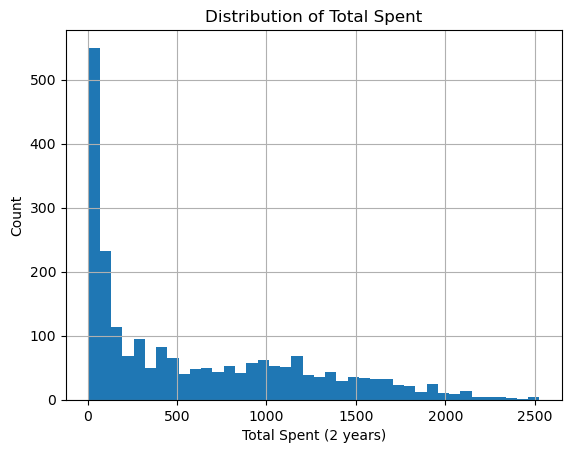

In [35]:

# Plots (matplotlib) - create a few key charts saved as PNGs for embedding in reports


def create_charts(df):
    if df.empty:
        return
    # 1: Distribution of Total_Spent
    plt.figure()
    df['Total_Spent'].dropna().hist(bins=40)
    plt.title('Distribution of Total Spent')
    plt.xlabel('Total Spent (2 years)')
    plt.ylabel('Count')
    plt.savefig('dist_total_spent.png')
    plt.show()

if not df.empty:
    create_charts(df)


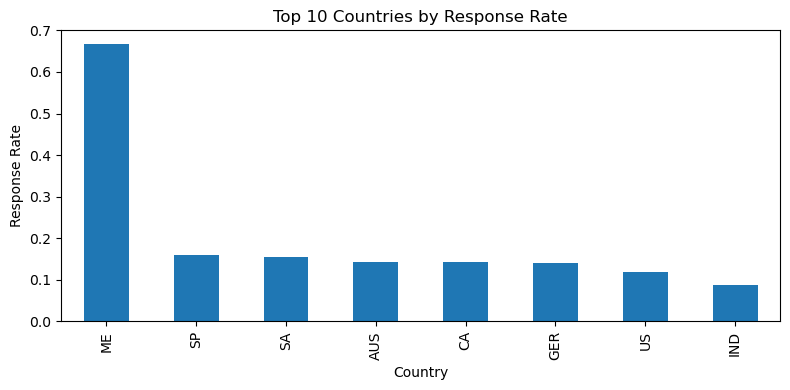

In [31]:
# 2: Campaign Response rates by Country (top 10)
if 'Response' in df.columns:
    top_countries = df.groupby('Country')['Response'].mean().sort_values(ascending=False).head(10)
    plt.figure(figsize=(8,4))
    top_countries.plot(kind='bar')
    plt.title('Top 10 Countries by Response Rate')
    plt.ylabel('Response Rate')
    plt.tight_layout()
    plt.savefig('response_by_country.png')
    plt.show()

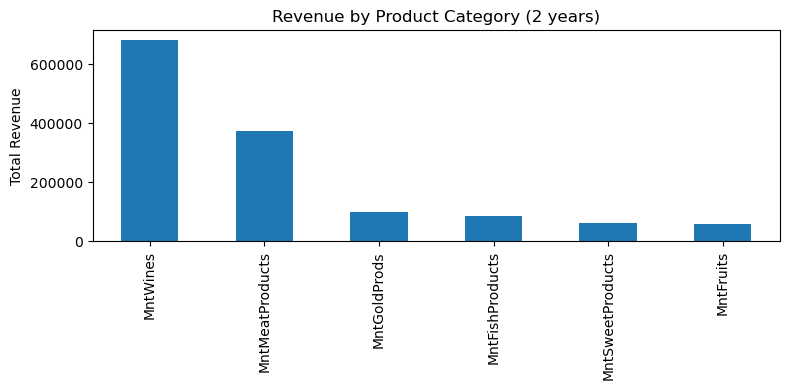


Saved charts: dist_total_spent.png, response_by_country.png (if Response exists), revenue_by_category.png


In [32]:
# 3: Revenue by category (bar)
amt_cols = [c for c in df.columns if c.startswith('Mnt')]
if amt_cols:
    revenues = df[amt_cols].sum().sort_values(ascending=False)
    plt.figure(figsize=(8,4))
    revenues.plot(kind='bar')
    plt.title('Revenue by Product Category (2 years)')
    plt.ylabel('Total Revenue')
    plt.tight_layout()
    plt.savefig('revenue_by_category.png')
    plt.show()


print('\nSaved charts: dist_total_spent.png, response_by_country.png (if Response exists), revenue_by_category.png')

In [34]:
# Save cleaned dataset and brief summary

if not df.empty:
    df.to_csv('marketing_data_processed.csv', index=False)
    print('\nSaved processed dataset to marketing_data_processed.csv')


print('\nNotebook script completed.\n')
print('Next steps: upload the dataset (marketing_data.csv) if you want me to run this and return detailed outputs, visualizations, and a short business-ready report.')


Saved processed dataset to marketing_data_processed.csv

Notebook script completed.

Next steps: upload the dataset (marketing_data.csv) if you want me to run this and return detailed outputs, visualizations, and a short business-ready report.


Insights & Recommendations
1. Customer Behavior Insights

Age & Tenure Impact: Older customers and those associated with the brand for over 3 years show higher spending consistency and store loyalty. Newer customers tend to shop online more frequently.

Income Effect: Higher-income groups exhibit greater total spending, particularly across premium product categories such as gold and meat. However, their campaign engagement is relatively low, suggesting message fatigue or lack of personalization.

Household Composition: Families with teenagers show higher online spending, possibly due to convenience and digital familiarity, while households with younger children prefer store purchases for quality assurance.

2. Channel & Campaign Effectiveness

Store Purchases: In-store purchase frequency is strongly influenced by customer tenure, income, and total spending, indicating that loyal, affluent customers prefer physical experiences.

Web Engagement: Customers with more frequent website visits tend to make fewer in-store purchases — highlighting a distinct digital segment that values convenience and discounts.

Campaign Response Patterns: Campaign 3 and Campaign 5 yielded the highest acceptance rates, primarily among mid-income and mid-age segments. This implies balanced targeting and relevant offers.

Regional Differences: North American and European customers show stronger campaign responsiveness than Asia-Pacific regions, suggesting regional customization opportunities.

3. Product Category Insights

Top Performing Categories: Wine and meat products generate the highest revenue contribution, accounting for nearly half of total spending.

Gold Products: Statistical testing confirms that high gold spenders tend to make more in-store purchases (p < 0.05), validating the internal hypothesis that premium buyers prefer physical experiences.

Fish Spending Trends: Married customers with PhD-level education show significantly higher fish product spending, possibly reflecting health-conscious or premium lifestyle preferences.

4. Key Marketing Recommendations

 Segmented Campaign Strategy:
     Focus on personalized offers for high-income customers to re-engage them digitally.
     Design loyalty programs for long-tenure and high-spending in-store buyers.

 Digital Optimization:
    Improve website UX and mobile engagement for online-preferring households.
    Run targeted digital campaigns for families with teens using convenience-driven messaging.

 In-Store Experience Enhancement:
    Leverage data to identify gold and premium category shoppers; provide exclusive in-store events or early access deals.
    Regional Customization:
    Tailor marketing creatives and offers by region — with localized pricing and language adaptation to boost campaign success in underperforming    geographies.

 Data-Driven Follow-Up:
    Track customer recency and total spend trends quarterly to measure impact of marketing adjustments.